In [1046]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import multiprocessing as mp
import time
import heapq
import itertools
import random


# load the faces from the norway data (calc)
def load_files(vfilename, efilename, ffilename):
    return np.loadtxt(vfilename), np.loadtxt(efilename, dtype='int'), np.loadtxt(ffilename, dtype='int')

# initialize the vertex dictionary
def initialize_vertex_dict(vertices, edges, faces):
    vertex_dict = {i: {'coords': vertices[i],'vertices':set(), 'faces': []} for i in range(vertices.shape[0])}
    vertices_list = []
   
            
            
    
    # add faces to dictionary
    
    for face in faces:
        for vertex_index in face:
            vertex_dict[vertex_index]['faces'].append(face)
    
    # Add edges to dictionary with consistent ordering
    for edge in edges:
        v1, v2 = edge
        
        #finding the adj vertices 
        vertex_dict[v1]['vertices'].add(v2)
        vertex_dict[v2]['vertices'].add(v1)

    return vertex_dict

def vertex_classification(vertex_dict):
    coordinates= np.array([vertex_dict[v]['coords']for v in vertex_dict])
    minimum= np.min(coordinates,axis=0)
    maximum= np.max(coordinates,axis=0)
    #print("MAX",maximum,"Minimum",minimum)

    classification = []

    for v in vertex_dict:
 
        vertex_coords= vertex_dict[v]['coords']
       #print("VERTEX",v,"COORDS",vertex_coords)
        if(vertex_coords==minimum).any() or (vertex_coords==maximum).any():
            continue
        else:
            classification.append(v)
        
    #print("numbers in",classification)
    
    return classification
    

    
def vertex_decimation(vertex_dict,classification):
    distance_heap=[]
    for vertex in classification:
    
    
        avg_normal =[]
        for face in vertex_dict[vertex]['faces']:
            #print("FACE",face)
            p1 = vertex_dict[face[0]]['coords']
            p2 = vertex_dict[face[1]]['coords']
            p3 = vertex_dict[face[2]]['coords']
            
            vectorA = p2 - p1
            vectorB = p3 - p1
            normal = np.cross(vectorA, vectorB)
            avg_normal.append(normal)
            
        #--calculating the avg plane--
        avg_normal=np.mean(avg_normal,axis=0)
        adj_vertices = (vertex_dict[vertex]['vertices'])
        avg_position= np.mean([vertex_dict[v]['coords']for v in adj_vertices],axis=0)
        d= -np.dot(avg_normal,avg_position)
        #the a b c d equation of the plane
        plane= np.append(avg_normal,d)
    
      
        #----checking distance from plane----
        a,b,c,d=plane
        x,y,z= vertex_dict[vertex]['coords']
        top= abs(a*x + b*y + c*z + d) 
        bottom= np.sqrt(a**2 + b**2 + c**2)
        distance= top/bottom
        #print("vertex",vertex,"distance",distance)
        distance_heap.append((distance,vertex))
    heapq.heapify(distance_heap)
    return distance_heap


def calc_boundary_edges(vertex_dict, vertex):
    global boundary_edges
    boundary_edges=[]
    for face in vertex_dict[vertex]['faces']:
        for i in range(3):
            edge = (face[i], face[(i + 1) % 3])
            if vertex not in edge:
                boundary_edges.append(edge)

    boundary_vertices = set()

    for edge in boundary_edges:
        boundary_vertices.update(edge)
    boundary_vertices = list(boundary_vertices)
    #print("Boundary edges: ", boundary_edges)
    #print("Boundary vertices:", boundary_vertices)
    
    return boundary_edges, boundary_vertices



def classify_vertices_on_sides(vertex_dict, boundary_vertices, v1, v2):
    p1 = vertex_dict[v1]['coords']
    p2 = vertex_dict[v2]['coords']
    
    split_line = p2 - p1
    
    side_A = [v1, v2]
    side_B = [v1, v2]

    if p2[0]-p1[0]==0:
        for vertex in boundary_vertices:
            if vertex==v1 or vertex==v2:
                continue
          
            coords= vertex_dict[vertex]['coords']
           
            if coords[0]< p1[0]:
                side_A.append(vertex)
            elif coords[0]> p1[0]:
                side_B.append(vertex)
            else:
                side_A.append(vertex)
                side_B.append(vertex)
    elif p2[1]-p1[1] == 0:
         for vertex in boundary_vertices:
            if vertex==v1 or vertex==v2:
                continue
           
            coords= vertex_dict[vertex]['coords']

            if coords[1] > p1[1]:
                side_A.append(vertex)
            elif coords[1]< p1[1]:
                side_B.append(vertex)
            else:
                side_A.append(vertex)
                side_B.append(vertex)
    else:
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])  # m = (y2 - y1) / (x2 - x1)
        intercept = p1[1] - slope * p1[0]  # b = y1 - m * x1
            
        for vertex in boundary_vertices:
            if vertex == v1 or vertex == v2:
                continue
  
            coords = vertex_dict[vertex]['coords']

            y_on_line = slope * coords[0] + intercept
                
            if coords[1] > y_on_line:
                side_A.append(vertex)
            elif coords[1] < y_on_line:
                side_B.append(vertex)

            else:
                side_A.append(vertex)
                side_B.append(vertex)
              
             
                
        
        
   
    
    return side_A, side_B

def triangulation(vertex_dict, distance_heap):
    try: 
        lowest_dist = heapq.heappop(distance_heap)
        vertex = lowest_dist[1]
        print("VETREX BEING PULLED FROM THE HEAP",vertex)
        
        boundary_edges, boundary_vertices = calc_boundary_edges(vertex_dict, vertex)
        boundary_edges_rep = boundary_edges.copy()
    
    
        side_A, side_A_new, side_B, side_B_new = find_non_adjacent_vertices(vertex_dict,boundary_edges_rep,boundary_vertices)
        print("SIDE A",side_A,"\n")
        side_A = recursion_trig(side_A,side_A_new)
        print("Side B",side_B,'\n')
        side_B = recursion_trig(side_B,side_B_new)
        side_A = list(side_A)
        side_B = list(side_B)
        new_faces = side_A + side_B
        faces = list(map(lambda i: new_faces[i:i+3], range(0, len(new_faces), 3)))
    
        
        for adjacent_vertex in boundary_vertices:
            vertex_dict[adjacent_vertex]['vertices'].discard(vertex)
            vertex_dict[adjacent_vertex]['faces'] = [face for face in vertex_dict[adjacent_vertex]['faces'] if vertex not in face]
          
        if vertex in vertex_dict:
            del vertex_dict[vertex]
        #for adjacent_vertex in boundary_vertices:
    
        
        for face in faces:
            v1,v2,v3= face 
            
            
            v1_x,v1_y,v1_z = vertex_dict[v1]['coords']
            v2_x,v2_y,v2_z = vertex_dict[v2]['coords']
            v3_x,v3_y,v3_z= vertex_dict[v3]['coords']
            if (v1_x == v2_x == v3_x) or (v1_y == v2_y == v3_y):
                faces.remove(face)
    
        for face in faces:
            for vertex in face:
                vertex_dict[vertex]['faces'].append(face)
            
        
        # Call the function to find non-adjacent vertices and split into sides
     
         
    
    
            
        
        vertex_dict=update_faces(vertex_dict, faces)
    
        
        classification=vertex_classification(vertex_dict)
    
        if not classification:
            print("The classification is empty")
        else:
            distance_heap= vertex_decimation(vertex_dict,classification)

    except Exception as e:
        # If any error occurs during the process, skip removing the vertex
        print("vertex trying to be removed",vertex)
        classification=vertex_classification(vertex_dict)
        print("the classification",classification)
        print(f"Error encountered during triangulation for vertex {vertex}: {e}")
        print("Skipping the removal of this vertex and moving on.")

    return vertex_dict, distance_heap



def find_non_adjacent_vertices(vertex_dict, edges, boundary_vertices):

    #initial_vertex = random.choice(boundary_vertices)


    
    initial_vertex =boundary_vertices[0]

    print("initial v",initial_vertex)

    print("EDGESSSSSS",edges)

    
    edges_initial = [edge for edge in edges if initial_vertex in edge]
    print("Those edges omg ",edges_initial)


    vertices = []
    for edge in edges_initial:
        for v in edge:

            if v != initial_vertex :
                vertices.append(v)
    
    print("The Vertices",vertices,'\n')
    v1, v2 = vertices[:2]

    print("FOR SPLIT LINE",v1,v2)
    

    #split_line, p1 = split(vertex_dict, v1, v2)

    # adding split line as a new boundary edge
    new_edge = [v1, v2]
    edges.append(new_edge)
    boundary_edges.append(new_edge)
    #print("THe new edge being formed", boundary_edges)
    
    
    side_A, side_B = classify_vertices_on_sides(vertex_dict, boundary_vertices, v1, v2)
    print("side a ",side_A,"side b", side_B)
    side_A_new = find_new_boundary_edges(side_A, edges)

    side_B_new = find_new_boundary_edges(side_B,edges)
   

    #print("New boundary edges:", side_A_new).=
    return side_A, side_A_new, side_B, side_B_new

def find_new_boundary_edges(vertices, original_edges):
    new_edges = []
    vertex_set = set(vertices)
    for edge in original_edges:
        if edge[0] in vertex_set and edge[1] in vertex_set:
            new_edges.append(edge)
 
    return new_edges

def recursion_trig(vertices, new_edges):
   # print("Vertices:", vertices)
    if len(vertices) == 3:
        #print("verticessss",vertices)
        return vertices
    else:
        side_A, side_A_new, side_B,side_B_new = find_non_adjacent_vertices(vertex_dict, new_edges, vertices)
        #print("le side",side_A)
        return recursion_trig(side_A, side_A_new) + recursion_trig(side_B,side_B_new)

def update_faces(vertex_dict,faces):
    # Iterate over each new face
    for face in faces:
        for i in range(3):
            v1 = face[i]
            v2 = face[(i + 1) % 3]
            
            vertex_dict[v1]['vertices'].add(v2)
            vertex_dict[v2]['vertices'].add(v1)

    return vertex_dict




In [1047]:
vertices,edges,faces = load_files('verticestest.txt','edgestest.txt','facestest.txt')

vertex_dict = initialize_vertex_dict(vertices,edges,faces)


classification=vertex_classification(vertex_dict)

distance_heap= vertex_decimation(vertex_dict,classification)

#vertex_dict, distance_heap = triangulation(vertex_dict,distance_heap)




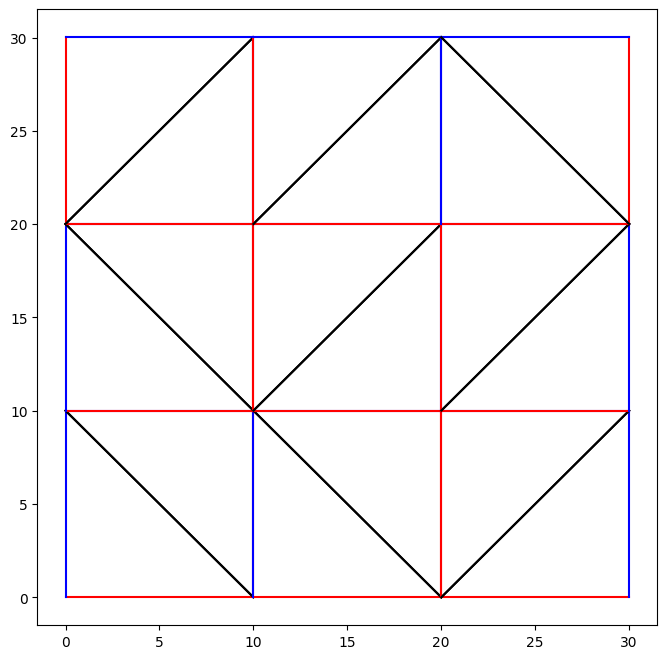

In [1048]:
vertices= np.loadtxt('verticestest.txt')
#getting all the x values 
x = vertices[:,0]

#getting all the y values 
y= vertices[:,1]
#getting all the z values 
z= vertices[:,2]
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot()
'''
#checking to see if getting vertices worked 
ax= plt.axes(projection='3d')
ax.plot_wireframe(xv,yv,arr)
plt.show()
'''



#for each line
for row in faces:
   
    a,b,c=row

    p1= (x[a],y[a],z[a])
    p2= (x[b],y[b],z[b])
    p3= (x[c],y[c],z[c])


    #plotting- 
    ax.plot([p1[0],p2[0]],
            [p1[1],p2[1]],color="red")
    ax.plot([p2[0],p3[0]],[p2[1],p3[1]],color="blue")
    ax.plot([p1[0],p3[0]],[p1[1],p3[1]],color="black")



plt.show()    

In [1033]:
#faces = np.array(new_faces, dtype=int)

faces_set = set()
for data in vertex_dict.values():
    for face in data['faces']:
        faces_set.add(tuple(face))
    
faces = np.array(list(faces_set), dtype=int)
print(faces)

[[ 2  6  7]
 [ 5  9  8]
 [ 5  4  8]
 [ 1  5  4]
 [ 1  0  4]
 [ 9 10 14]
 [11 10 14]
 [ 6  7 11]
 [11 15 14]
 [ 5  9 10]
 [ 5  6 10]
 [ 6 10 11]
 [ 2  6  5]
 [ 2  1  5]
 [ 8  9 13]
 [ 2  3  7]
 [ 8 12 13]
 [ 9 13 14]]


In [1035]:
print("vertex that will be removed",distance_heap[0][1])
print("vertex",distance_heap[0][1],"coords",vertex_dict[distance_heap[0][1]]['coords'])

print("distance",distance_heap)


vertex that will be removed 9
vertex 9 coords [  10.0050025   20.010005  1552.5      ]
distance [(np.float64(0.019806054974505407), 9), (np.float64(0.019824514901861604), 10), (np.float64(0.09916151479833904), 5), (np.float64(0.09949929078419023), 6)]


In [1053]:
if len(distance_heap) !=0:
    vertex_dict, distance_heap = triangulation(vertex_dict,distance_heap)
else:
    print("done")
#faces = np.array(new_faces, dtype=int)

faces_set = set()
for data in vertex_dict.values():
    for face in data['faces']:
        faces_set.add(tuple(face))
    
faces = np.array(list(faces_set), dtype=int)
print(faces)

done
[[ 8  7 11]
 [ 1  0  4]
 [11 15 14]
 [ 8  2  4]
 [ 4  2  1]
 [14  8 11]
 [ 8  2  7]
 [14  8 13]
 [ 2  3  7]
 [ 8 12 13]]


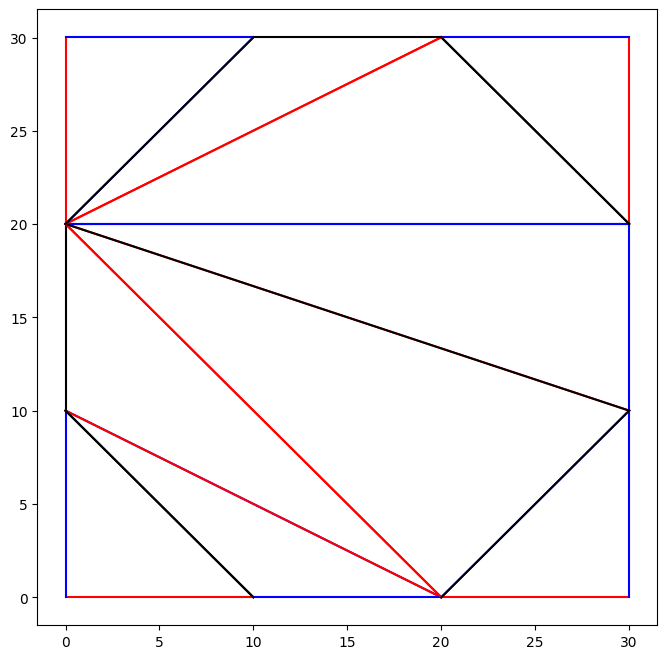

In [1054]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot()

# using the coordinates from vertex dict
for face in faces:
    p1 = vertex_dict[face[0]]['coords']
    p2 = vertex_dict[face[1]]['coords']
    p3 = vertex_dict[face[2]]['coords']

    # Plot edges of the face
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color="red")
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], color="blue")
    ax.plot([p1[0], p3[0]], [p1[1], p3[1]], color="black")

In [1045]:
'''
would be used to delete by percentage 
int_vertices = len(vertex_dict)
print(int_vertices)
target_vertex_per= int(int_vertices * .4)
while len(vertex_dict) > target_vertex_per:
    if len(distance_heap) !=0:
        vertex_dict, distance_heap = triangulation(vertex_dict,distance_heap)
        current_vertex_count = len(vertex_dict)
    #print("Vertcies",vertices)
    #print("FACES", faces)
        if current_vertex_count<=target_vertex_per:
            break
    else:
        print("Empty")
        break

vertices = np.array([data['coords'] for data in vertex_dict.values()])
#faces = np.array(new_faces, dtype=int)

faces_set = set()
for data in vertex_dict.values():
    for face in data['faces']:
        faces_set.add(tuple(face))
    
faces = np.array(list(faces_set), dtype=int)
'''

'\nint_vertices = len(vertex_dict)\nprint(int_vertices)\ntarget_vertex_per= int(int_vertices * .4)\nwhile len(vertex_dict) > target_vertex_per:\n    if len(distance_heap) !=0:\n        vertex_dict, distance_heap = triangulation(vertex_dict,distance_heap)\n        current_vertex_count = len(vertex_dict)\n    #print("Vertcies",vertices)\n    #print("FACES", faces)\n        if current_vertex_count<=target_vertex_per:\n            break\n    else:\n        print("Empty")\n        break\n\nvertices = np.array([data[\'coords\'] for data in vertex_dict.values()])\n#faces = np.array(new_faces, dtype=int)\n\nfaces_set = set()\nfor data in vertex_dict.values():\n    for face in data[\'faces\']:\n        faces_set.add(tuple(face))\n    \nfaces = np.array(list(faces_set), dtype=int)\n'